In [ ]:
import sagemaker
from sagemaker import get_execution_role
import sys
#!{sys.executable} -m pip install opencv-python
#!{sys.executable} -m pip install mxnet

role = get_execution_role()
print(role)
sess = sagemaker.Session()

In [2]:
bucket = 'sagemaker-mnist-michael' # custom bucket name.
# bucket = sess.default_bucket()
prefix = 'mynotebook-insulator-github-json'

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

In [ ]:
### Download dataset
!git clone https://github.com/InsulatorData/InsulatorDataSet.git

In [6]:
import json
import xml.etree.cElementTree as et
import os

### Prepare dataset, Convert XML to Json 

def xml2json(path):
    tree=et.parse(path)
    root=tree.getroot()

    data = {}
    annotations=[]
    categories=[]
    image_size=[]
    jsondata = json.loads(json.dumps(data))

    file = root.find('filename').text + '.jpg'
    jsondata['file'] = file
    image1size = {'width':{}, 'height':{}, 'depth':{}}
    
    myclass = {'class_id':0, 'name' :'insulator' }
    # print(file)

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text
    depth = size.find('depth').text

    image1size['width'] = int(width)
    image1size['height'] = int(height)
    image1size['depth'] = int(depth)
    image_size.append(image1size)
    jsondata['image_size']= image_size

    # print(width, height, depth)
    for Object in root.findall('object'):
        # name= Object.find('name').text
        # print (name)
        mybox = {'class_id':{},'top':{},'left':{},'width':{},'height':{}}
        bndbox=Object.find('bndbox')
        xmin=bndbox.find('xmin').text
        ymin=bndbox.find('ymin').text
        xmax=bndbox.find('xmax').text
        ymax=bndbox.find('ymax').text
        mybox['class_id'] = int(0)
        ###mybox['top'] = int(xmin)
        ###mybox['left'] = int(ymin)
        ###mybox['width'] = int(xmax)
        ###mybox['height'] = int(ymax)
        #########################################################
        mybox['top'] = int(ymin)
        mybox['left'] = int(xmin)
        mybox['width'] = int(xmax) - int(xmin)
        mybox['height'] = int(ymax) -int(ymin)
        #########################################################
        
        annotations.append(mybox)
        categories.append(myclass)
        # print (xmin,ymin,xmax,ymax)

    jsondata['annotations'] = annotations
    jsondata['categories'] = categories
    jsonarticle = json.dumps(jsondata, ensure_ascii=False)
    # print(jsonarticle)
    # write json to a file
    name, sufx = os.path.splitext(path)
    #print(name)
    jsonfile = open(name + '.json' ,'w')
    jsonfile.write(jsonarticle)
    jsonfile.close()

def convertall(rootDir = './'):
    Lists = os.listdir(rootDir)
    Lists.sort(key=str.lower)
    for lists in Lists:
        path = os.path.join(rootDir, lists)
        name, sufx = os.path.splitext(lists)
        if sufx == '.xml' :
            xml2json(path)
            #print(path)



In [7]:
#### Clean old json files

!rm -rf InsulatorDataSet/Normal_Insulators/labels/*.json
!rm -rf InsulatorDataSet/Defective_Insulators/labels/insulator/*.json
!rm -rf InsulatorDataSet/Defective_Insulators/labels/json_insulator/*.json
!rm -rf InsulatorDataSet/Normal_Insulators/json_labels/*.json

In [8]:
#### Convert XML to Json formation
convertall('InsulatorDataSet/Normal_Insulators/labels')
convertall('InsulatorDataSet/Defective_Insulators/labels/insulator/')

##### mv json file to a dedicated foulder
!mkdir InsulatorDataSet/Normal_Insulators/json_labels
!mkdir InsulatorDataSet/Defective_Insulators/labels/json_insulator/
!mv InsulatorDataSet/Normal_Insulators/labels/*.json  InsulatorDataSet/Normal_Insulators/json_labels
!mv InsulatorDataSet/Defective_Insulators/labels/insulator/*.json InsulatorDataSet/Defective_Insulators/labels/json_insulator/


In [9]:
##### Count the number of images
!ls -l InsulatorDataSet/Normal_Insulators/images | grep '^-' | wc -l


600


#### try to read and draw the images and label as sample

In [10]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json

def visualize_sample(img_file, json_file):
    
        img = mpimg.imread(img_file)
        plt.imshow(img)    
        with open(json_file, 'r') as jsonfile:
            for line in jsonfile:
                temp = json.loads(line)
                width = temp['image_size'][0]['width']
                height = temp['image_size'][0]['height']
                for box in temp['annotations']:
                    top = int (box['top']) 
                    left = int (box['left']) 
                    width = int (box['width']) 
                    height = int (box['height']) 
                    color = (random.random(), random.random(), random.random())
                    rect = plt.Rectangle((left, top), width, height, fill=False, edgecolor=color,linewidth=3)
                    plt.gca().add_patch(rect)
                    plt.gca().text(left, top, 'Insulator',fontsize=12, color='white')
        plt.show()
        

-------- train dataset  --------


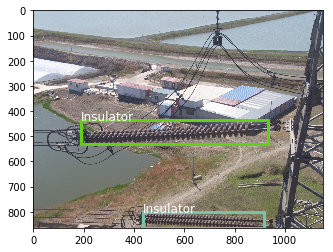

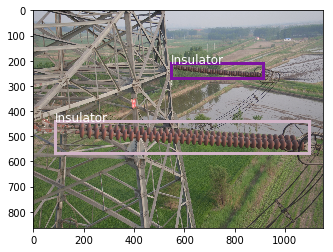

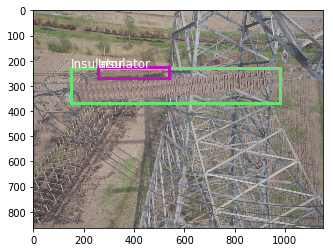

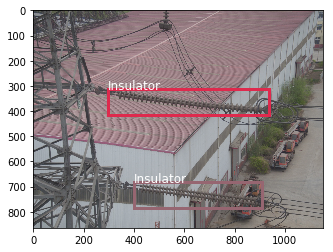

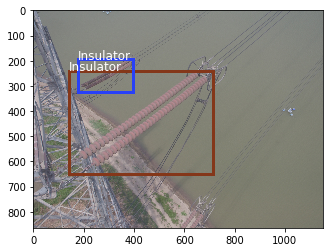

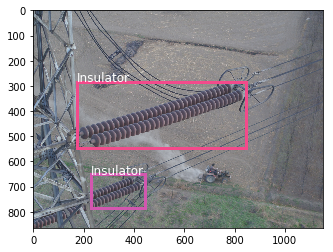

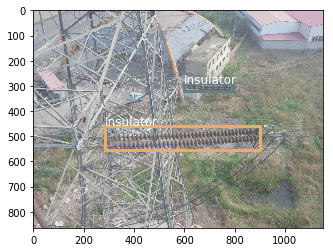

--------  validation dataset  --------


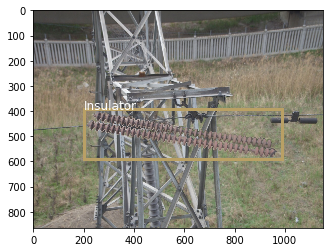

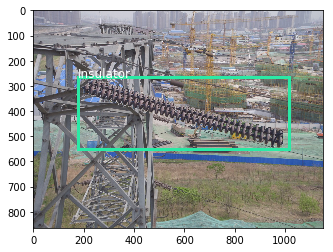

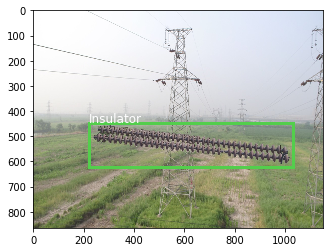

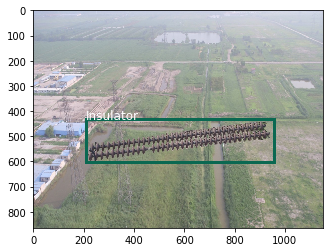

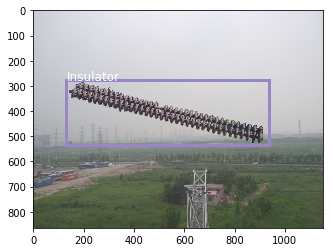

In [11]:
print('-------- train dataset  --------')
visualize_sample('InsulatorDataSet/Normal_Insulators/images/0176.jpg','InsulatorDataSet/Normal_Insulators/json_labels/0176.json')
visualize_sample('InsulatorDataSet/Normal_Insulators/images/0638.jpg','InsulatorDataSet/Normal_Insulators/json_labels/0638.json')
visualize_sample('InsulatorDataSet/Normal_Insulators/images/0926.jpg','InsulatorDataSet/Normal_Insulators/json_labels/0926.json')
visualize_sample('InsulatorDataSet/Normal_Insulators/images/1617.jpg','InsulatorDataSet/Normal_Insulators/json_labels/1617.json')
visualize_sample('InsulatorDataSet/Normal_Insulators/images/2400.jpg','InsulatorDataSet/Normal_Insulators/json_labels/2400.json')
visualize_sample('InsulatorDataSet/Normal_Insulators/images/1778.jpg','InsulatorDataSet/Normal_Insulators/json_labels/1778.json')
visualize_sample('InsulatorDataSet/Normal_Insulators/images/2729.jpg','InsulatorDataSet/Normal_Insulators/json_labels/2729.json')
print('--------  validation dataset  --------')
visualize_sample('InsulatorDataSet/Defective_Insulators/images/017.jpg','InsulatorDataSet/Defective_Insulators/labels/json_insulator/017.json')
visualize_sample('InsulatorDataSet/Defective_Insulators/images/053.jpg','InsulatorDataSet/Defective_Insulators/labels/json_insulator/053.json')
visualize_sample('InsulatorDataSet/Defective_Insulators/images/125.jpg','InsulatorDataSet/Defective_Insulators/labels/json_insulator/125.json')
visualize_sample('InsulatorDataSet/Defective_Insulators/images/186.jpg','InsulatorDataSet/Defective_Insulators/labels/json_insulator/186.json')
visualize_sample('InsulatorDataSet/Defective_Insulators/images/225.jpg','InsulatorDataSet/Defective_Insulators/labels/json_insulator/225.json')

In [12]:
%%time

### Upload jpg image dataset to S3
train_channel = prefix + '/train'
train_annotation_channel = prefix + '/train_annotation'

validation_channel = prefix + '/validation'
validation_annotation_channel = prefix + '/validation_annotation'


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.2 µs


In [ ]:
sess.upload_data(path='InsulatorDataSet/Normal_Insulators/images', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='InsulatorDataSet/Normal_Insulators/json_labels', bucket=bucket, key_prefix=train_annotation_channel)
#### Training dataset

In [ ]:
sess.upload_data(path='InsulatorDataSet/Defective_Insulators/images', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='InsulatorDataSet/Defective_Insulators/labels/json_insulator', bucket=bucket, key_prefix=validation_annotation_channel)
#### Validation dataset

In [15]:
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)

In [16]:
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

In [17]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
### model will be upload to above s3 bucket

In [18]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

### Sagemaker estimator parameter for training

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `30` epochs.

In [19]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=1,
                             mini_batch_size=16,
                             epochs=30,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=300,
                             num_training_samples=600)

### hyperparameters can be refered to https://docs.aws.amazon.com/zh_cn/sagemaker/latest/dg/object-detection-api-config.html

In [20]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}



In [ ]:
od_model.fit(inputs=data_channels, logs=True)

tracking for job: object-detection-2019-11-22-09-56-13-007
Maximum mAP: 0.999422 


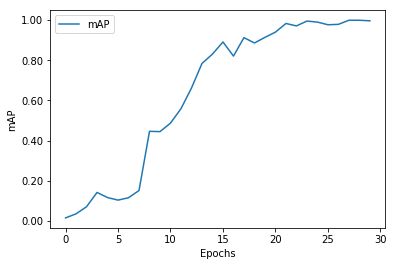

In [22]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

client = boto3.client('logs')
BASE_LOG_NAME = '/aws/sagemaker/TrainingJobs'

def plot_object_detection_log(model, title):
    logs = client.describe_log_streams(logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name)
    cw_log = client.get_log_events(logGroupName=BASE_LOG_NAME, logStreamName=logs['logStreams'][0]['logStreamName'])

    mAP_accs=[]
    for e in cw_log['events']:
        msg = e['message']
        if 'validation mAP <score>=' in msg: 
            # train cross_entropy <loss>=   validation mAP <score>=  smooth_l1 <loss>=
            num_start = msg.find('(')
            num_end = msg.find(')')
            mAP = msg[num_start+1:num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print('Maximum mAP: %f ' % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel('Epochs')
    plt.ylabel('mAP')
    val_plot,   = ax.plot(range(len(mAP_accs)),   mAP_accs,   label='mAP')
    plt.legend(handles=[val_plot])
    # ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    plt.show()
    
plot_object_detection_log(od_model, 'tracking for job: ' + od_model._current_job_name)

In [23]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

#### This will allow us to make predictions (or inference) from the model

---------------------------------------------------------------------------------------------------------------!

##################################################
#####             Inference                #######
##################################################

In [24]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):

        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img = mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]

        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh :
                continue
                
            cls_id = int(klass)
            color = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=color,
                                 linewidth=1)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=color, alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

In [25]:
def sample_test(file_name = './TestSet/1.jpg'):
    
    import json
    import time
        
    with open(file_name, 'rb') as image:
        f = image.read()
        b = bytearray(f)
        ne = open('n.txt','wb')
        ne.write(b)

    object_detector.content_type = 'image/jpeg'
    time1 = time.time()
    results = object_detector.predict(b)
    time2 = time.time()
    print('time cost:' + str(time2 - time1))
    detections = json.loads(results)
    # print (detections)

    object_categories = ['insulator']
    # Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
    threshold = 0.35

    # Visualize the detections.
    visualize_detection(file_name, detections['prediction'], object_categories, threshold)


In [26]:
import os

def do_test(IMAGES_DIR = './'):
    img_list = !ls $IMAGES_DIR
    IM_COUNT = len(img_list)
    
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        filename = IMAGES_DIR + img_list[curr_img]
        sample_test(filename)
        

time cost:0.5691506862640381


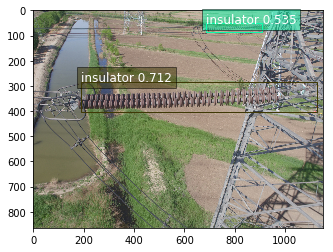

time cost:0.5527784824371338


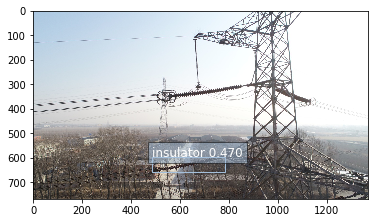

time cost:0.5880646705627441


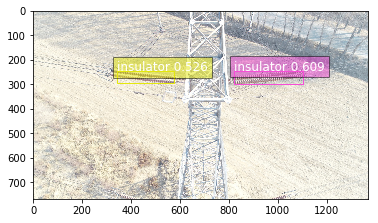

time cost:0.556084156036377


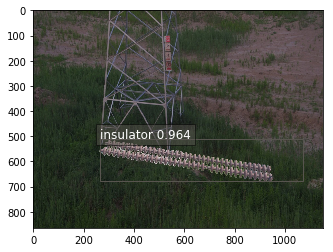

time cost:0.5523784160614014


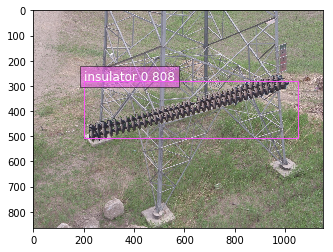

In [30]:
do_test('TestSet/')

###############################################
###    Some picture processing code         ###  
###############################################


In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def sharpimage(filename = 'InsulatorDataSet/Defective_Insulators/images/225.jpg'):
    image = mpimg.imread(filename)
    #对图像进行灰度化处理
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray)  
    #对灰度化图像进行标准化，该函数的参数依次是：输入数组，输出数组，最小值，最大值，标准化模式。
    cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32)
    # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    image = cv2.filter2D(image, -1, kernel=kernel) 

    plt.imshow(image)
    plt.savefig(filename, dpi=200, bbox_inches='tight')
    plt.show()


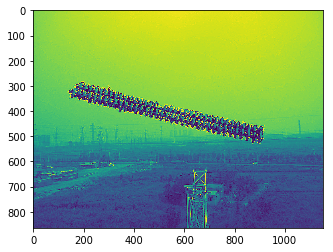

In [32]:
sharpimage()

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def sharpimage2(filename = 'InsulatorDataSet/Defective_Insulators/images/002.jpg'):
    image = cv2.imread(filename)
    #对图像进行灰度化处理
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #对图像锐化
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32)
    # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    image = cv2.filter2D(image, -1, kernel=kernel) 
    #对灰度化图像进行标准化，该函数的参数依次是：输入数组，输出数组，最小值，最大值，标准化模式。
    #cv2.normalize(image, image, 0, 1,   cv2.NORM_MINMAX)
    cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)

    plt.imshow(image)
    cv2.imwrite(filename, image)
    plt.show()

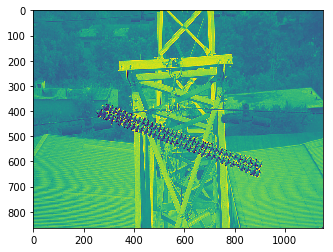

In [34]:
sharpimage2()

In [78]:
import os

def sharpallimages(IMAGES_DIR = 'InsulatorDataSet/Defective_Insulators/images/'):
    _im_list = !ls $IMAGES_DIR
    IM_COUNT = len(_im_list)
    
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        filename = IMAGES_DIR + _im_list[curr_img]
        sharpimage2(filename)
       

In [79]:
#sharpallimages()

####################################################

In [80]:
import os
def sharpallimages2(IMAGES_DIR2 = 'InsulatorDataSet/Normal_Insulators/images/'):
    _im_list = !ls $IMAGES_DIR2
    IM_COUNT = len(_im_list)
    
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        filename = IMAGES_DIR2 + _im_list[curr_img]
        sharpimage2(filename)

In [81]:
# sharpallimages2()

####################################################

In [ ]:
### Delete the Endpoint

sagemaker.Session().delete_endpoint(object_detector.endpoint)